In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
import torchvision
from torchvision import transforms
from tqdm import tqdm

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jaimetrickz/galaxy-zoo-2-images")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\sommacam\.cache\kagglehub\datasets\jaimetrickz\galaxy-zoo-2-images\versions\1


In [3]:
image_preprocessing = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
        )
])

In [4]:
data = datasets.ImageFolder(root=path, transform=image_preprocessing)
print(f"Taille du jeu d'image : {len(data)}")

Taille du jeu d'image : 243434


In [5]:
# Define the size of the validation set
# Define the size of the validation and test sets
validation_split = 0.3
test_split = 0.2

# Calculate sizes of validation and test sets
val_size = int(validation_split * len(data))
test_size = int(test_split * len(data))
train_size = len(data) - val_size - test_size

# Split the dataset into training, validation, and test sets
train_data, val_data, test_data = random_split(data, [train_size, val_size, test_size])

# Create data loaders for training, validation, and test sets
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..0.78534126].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.5045809].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.4018323].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.3418957].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..0.87952733].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.4360819].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.

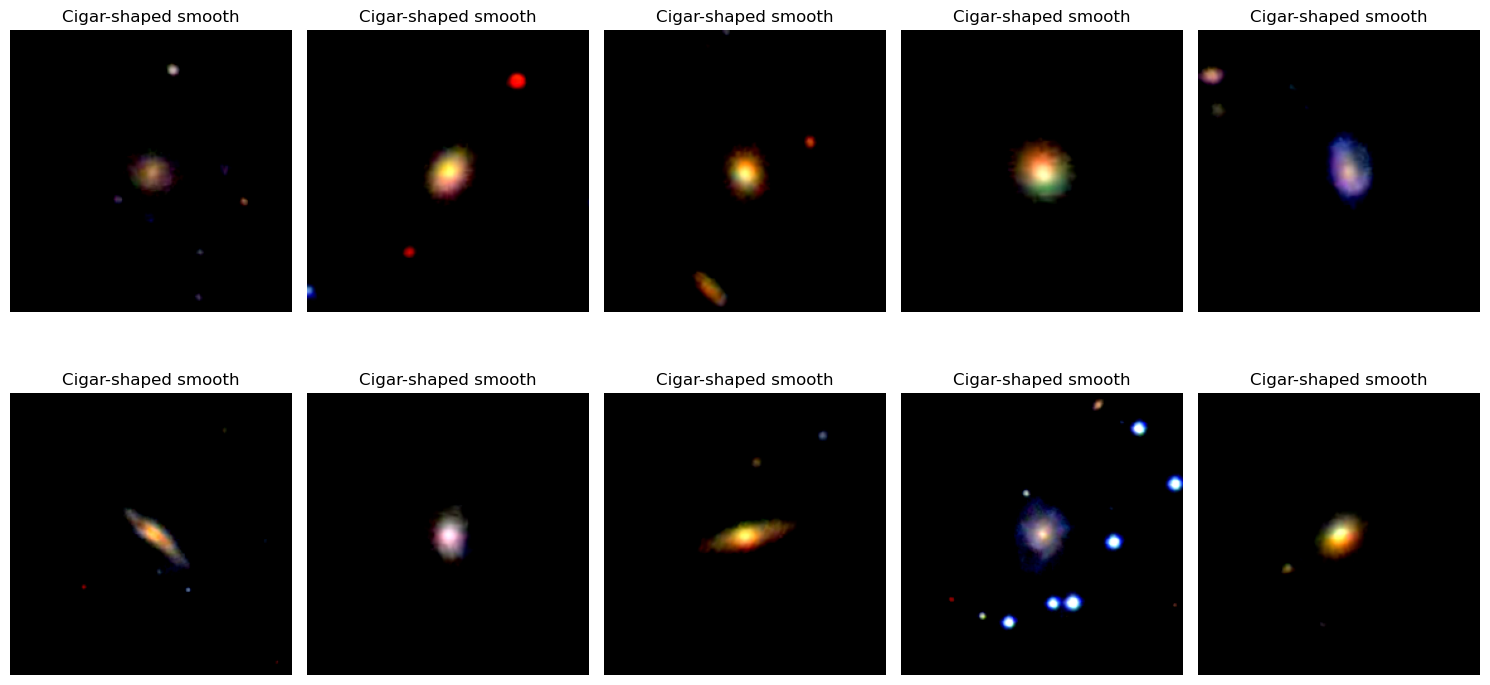

In [6]:
class_labels = ["Cigar-shaped smooth", "In between smooth", "completely round smooth", "edge-on", "spiral"]

dataiter = iter(train_loader)
images, labels = next(dataiter)

# Function to show images with labels
def imshow(img, label):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"{class_labels[label]}")
    plt.axis("off")

# Subplot to display 10 images
plt.figure(figsize=(15, 8))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    index = np.random.randint(0, len(images))
    imshow(torchvision.utils.make_grid(images[index]), labels[index].item())

plt.tight_layout()
plt.show()

In [7]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

Nombre d'images dans le dataset Galaxy Zoo 2: 243434
Classes disponibles: ['images_gz2']
DataLoader créé avec succès - Batch size: 128
Shape d'un batch: torch.Size([128, 3, 64, 64])
Valeurs min/max d'un batch: -1.000/1.000
Affichage d'exemples d'images de galaxies:


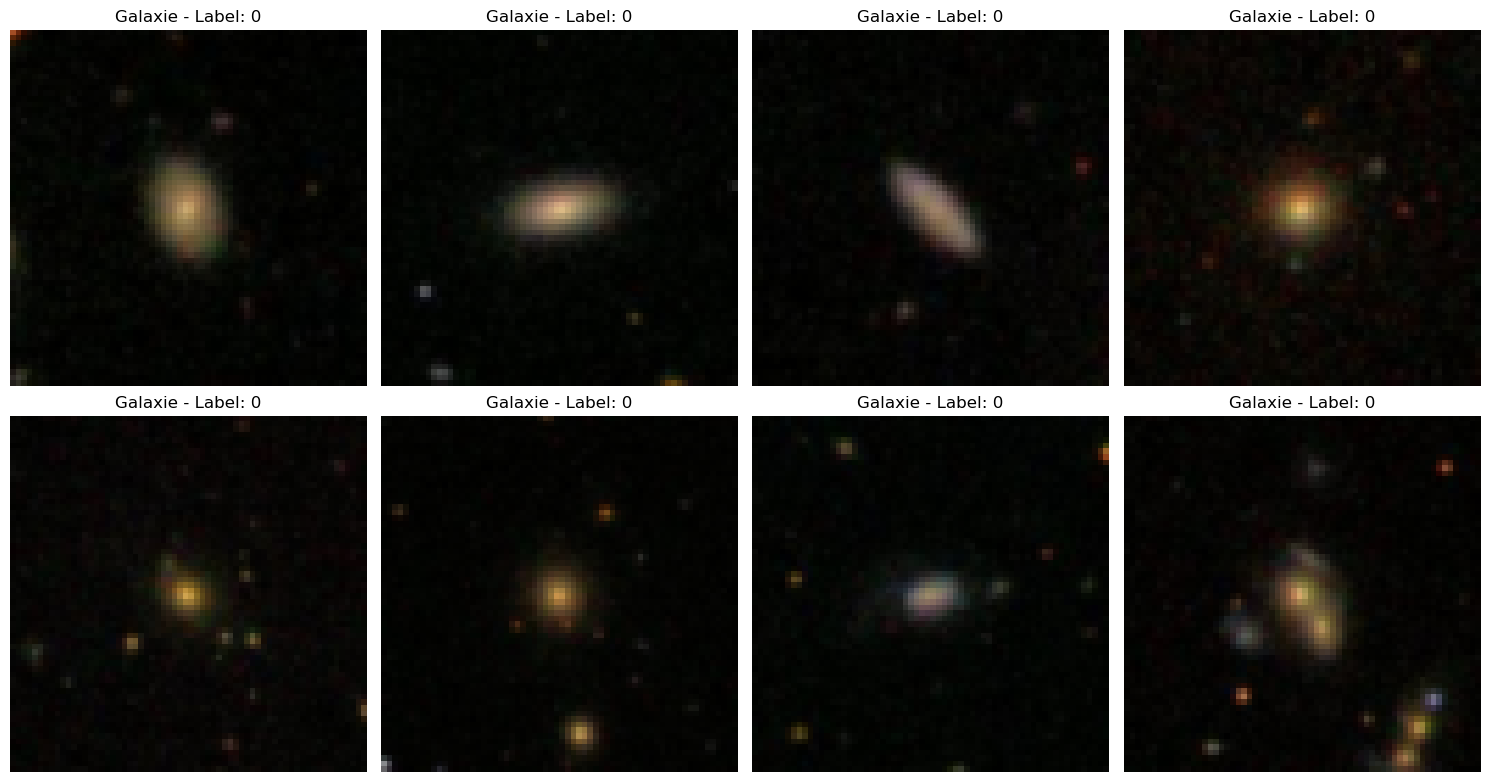

In [8]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    """
    Charge le dataset Galaxy Zoo 2 depuis Kaggle avec les transformations appropriées
    """
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)

    # Utiliser le dataset Galaxy Zoo 2 téléchargé depuis Kaggle
    # path est défini dans une cellule précédente via kagglehub
    galaxy_data = datasets.ImageFolder(root=path, transform=data_transform)
    
    return galaxy_data

def show_tensor_image(image):
    """
    Affiche une image tensor en format PIL
    """
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

# Charger le dataset Galaxy Zoo 2
data = load_transformed_dataset()
print(f"Nombre d'images dans le dataset Galaxy Zoo 2: {len(data)}")
print(f"Classes disponibles: {data.classes}")

# Créer le dataloader avec gestion d'erreur pour éviter les crashs
try:
    dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, 
                           drop_last=True, num_workers=0)  # num_workers=0 pour éviter les conflits
    print(f"DataLoader créé avec succès - Batch size: {BATCH_SIZE}")
except Exception as e:
    print(f"Erreur lors de la création du DataLoader: {e}")
    # Réduire la taille du batch en cas de problème
    BATCH_SIZE = 32
    dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, 
                           drop_last=True, num_workers=0)
    print(f"DataLoader créé avec batch size réduit: {BATCH_SIZE}")

# Test du dataloader
try:
    test_batch = next(iter(dataloader))
    print(f"Shape d'un batch: {test_batch[0].shape}")
    print(f"Valeurs min/max d'un batch: {test_batch[0].min():.3f}/{test_batch[0].max():.3f}")
except Exception as e:
    print(f"Erreur lors du test du dataloader: {e}")

# Affichage d'exemples d'images du dataset Galaxy Zoo 2
def show_galaxy_samples(dataloader, num_samples=8):
    """
    Affiche quelques exemples d'images de galaxies
    """
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    
    plt.figure(figsize=(15, 8))
    for i in range(min(num_samples, len(images))):
        plt.subplot(2, 4, i + 1)
        show_tensor_image(images[i])
        plt.title(f"Galaxie - Label: {labels[i].item()}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Afficher des exemples
print("Affichage d'exemples d'images de galaxies:")
show_galaxy_samples(dataloader)

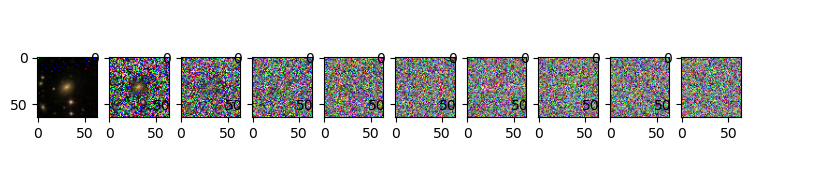

In [9]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(10,2))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

In [10]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

In [11]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [12]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(10,2))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

Calcul sur cuda


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 | step 000 Loss: 0.809863805770874 


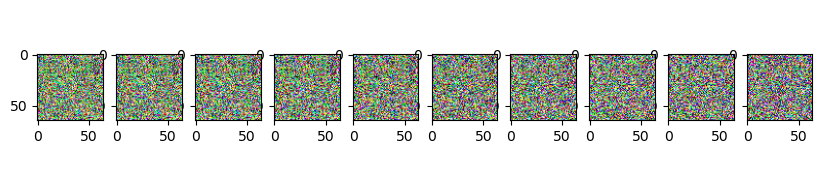

  2%|▏         | 2/100 [16:31:40<807:28:12, 29662.16s/it]

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Calcul sur {device}")
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

for epoch in tqdm(range(epochs)):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()